In [120]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

#BiocManager::install("AnnotationDbi")
#BiocManager::install("org.Hs.eg.db")
BiocManager::install("EnsDb.Hsapiens.v75")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)

Installing package(s) 'EnsDb.Hsapiens.v75'

Old packages: 'askpass', 'backports', 'BH', 'boot', 'broom', 'callr', 'caret',
  'class', 'cli', 'clipr', 'codetools', 'colorspace', 'covr', 'cowplot',
  'curl', 'data.table', 'dbplyr', 'digest', 'dplyr', 'DT', 'evaluate', 'fansi',
  'forcats', 'foreach', 'formatR', 'fs', 'future', 'future.apply', 'generics',
  'ggplot2', 'glmnet', 'globals', 'glue', 'gower', 'gplots', 'haven', 'hexbin',
  'hms', 'htmltools', 'htmlwidgets', 'httpuv', 'httr', 'igraph', 'ipred',
  'iterators', 'jsonlite', 'KernSmooth', 'knitr', 'labeling', 'later',
  'lattice', 'lava', 'leiden', 'lubridate', 'markdown', 'MASS', 'matrixStats',
  'mgcv', 'mime', 'ModelMetrics', 'modelr', 'nlme', 'nloptr', 'nnet',
  'numDeriv', 'openssl', 'patchwork', 'pbapply', 'pbdZMQ', 'pillar',
  'pkgbuild', 'pkgconfig', 'plyr', 'prettyunits', 'processx', 'prodlim',
  'progress', 'promises', 'ps', 'quantmod', 'R.methodsS3',

In [121]:
library(edgeR)
library(ggplot2)
library(ggrepel)
library(reshape2)
library(scales)
library(gridExtra)
library(EnsDb.Hsapiens.v75)  # v75 for hg19

In [1]:
# BD153 data: 049 to 084
nums = 49:84
dir = "../../../files/201023Van/bd153/D20-2480"
fns = sapply(nums, function(x) paste(dir, as.character(x), ".featureCounts", sep=''))

In [33]:
dfs = list()
for (i in 1:length(nums)) {
    df = read.table(fns[i], skip = 1, header = TRUE, row.names=1)
    df = df[,6]
    dfs[[i]] = df
}
count_data = do.call(cbind, dfs)

In [34]:
df = read.table(fns[1], skip = 1, header = TRUE, row.names=1)
rownames(count_data) = rownames(df)
head(count_data)

ENSG00000223972.4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000227232.4,4,6,3,5,2,3,3,0,6,4,...,1,2,1,2,4,3,5,2,3,3
ENSG00000243485.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000237613.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000268020.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSG00000240361.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
conds = c(rep("THP1_HU_2d", 4), rep("THP1_HU_4d", 4), 
          rep("THP1_BRQ_2d", 4), rep("THP1_BRQ_4d", 4),
          #rep("THP1_DMSO_2d", 4), rep("THP1_DMSO_4d", 4),
          rep("THP1_DMSO", 8),
          rep("U937_HU_4d", 4), rep("U937_BRQ_4d", 4),
          rep("U937_DMSO_4d", 4))

In [145]:
thp1_data = count_data[,c(1:7,9:13,15:24)]  # removing samples 8 and 14, which were empty
thp1_conds = conds[c(1:7,9:13,15:24)]
u937_data = count_data[,26:36]  # removing sample 25 which is low 
u937_conds = conds[26:36]

In [132]:
write.csv(count_data, "../output/201113_bd153_count_matrix.csv", quote=FALSE)

## THP1 with limma-voom

In [23]:
d0 <- DGEList(thp1_data)
d0 <- calcNormFactors(d0)
cutoff <- 5
drop <- which(apply(cpm(d0), 1, max) < cutoff)
d <- d0[-drop,] 
dim(d) # number of genes left

[1] 12488    22

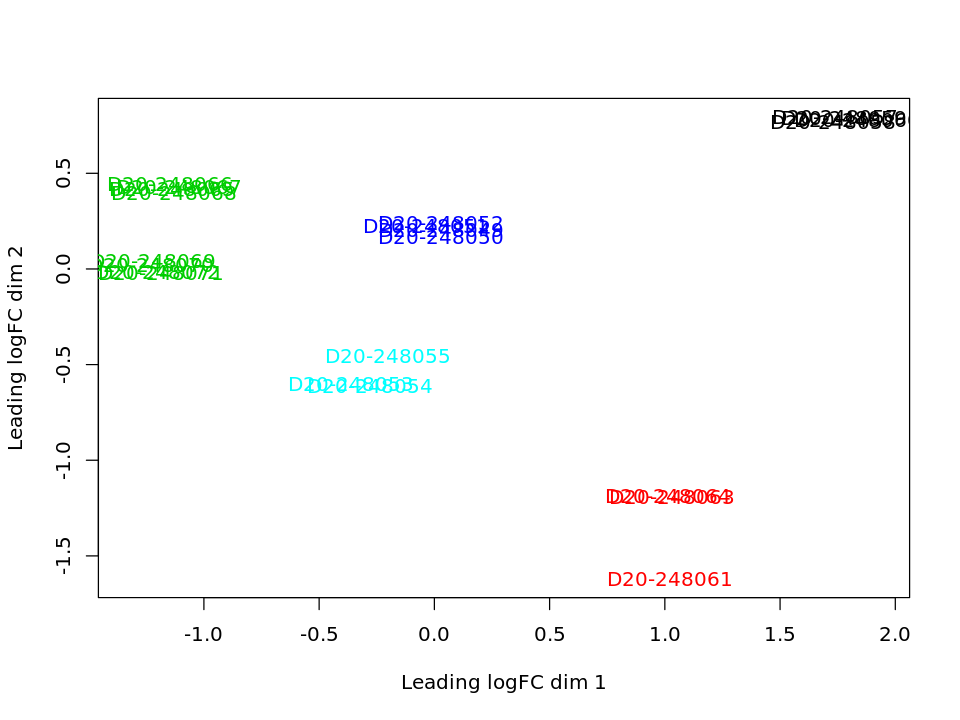

In [24]:
conds = as.character(thp1_conds)
plotMDS(d, col = as.numeric(as.factor(thp1_conds)))

,condsTHP1_BRQ_2d,condsTHP1_BRQ_4d,condsTHP1_DMSO,condsTHP1_HU_2d,condsTHP1_HU_4d
ENSG00000225972.1,9.605789,10.501095,10.159873,10.304359,10.554485
ENSG00000225630.1,8.696152,9.566654,9.350986,8.980108,9.561565
ENSG00000237973.1,12.625923,13.129294,11.893001,11.763915,12.107351
ENSG00000229344.1,10.108395,11.013041,10.141994,9.847951,10.243854
ENSG00000240409.1,-1.130693,1.983149,1.453120,1.587395,1.510680
ENSG00000248527.1,9.512613,10.785432,10.114404,9.899562,10.297125


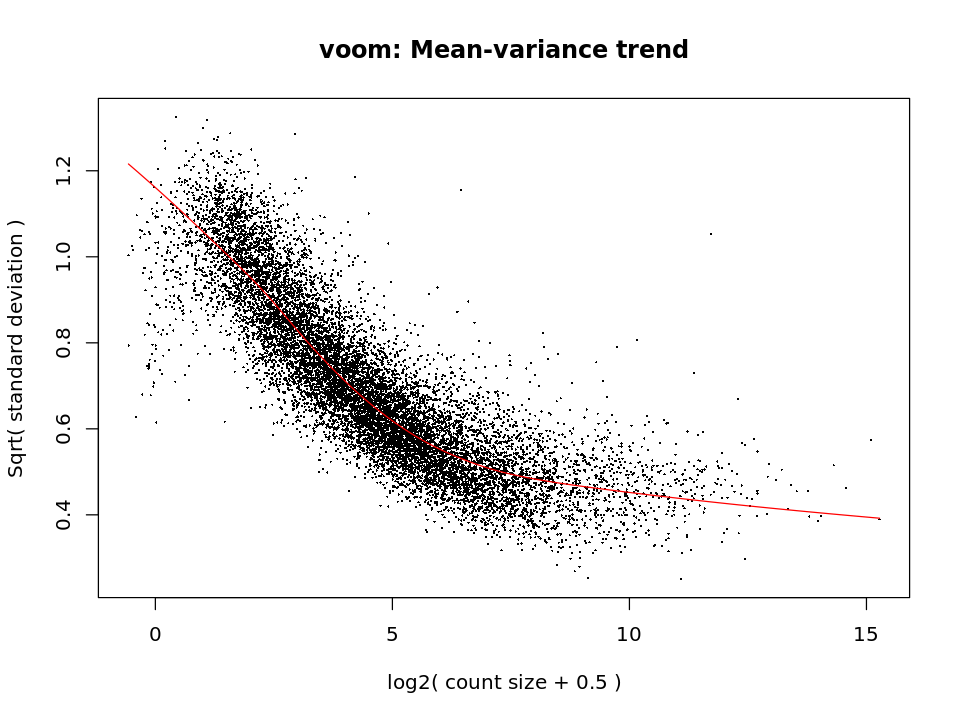

In [25]:
mm <- model.matrix(~0 + conds)
y <- voom(d, mm, plot = T)
fit <- lmFit(y, mm)
head(coef(fit))

In [124]:
process_res = function(res) {
    tmp <- contrasts.fit(fit, res)
    tmp <- eBayes(tmp)
    res <- topTable(tmp, sort.by = "P", n = Inf)
    
    # Return the Ensembl IDs for a set of genes
    rownames(res) = as.character(sapply(rownames(res), function(x) strsplit(x, '[.]')[[1]][1]))
    annotations_orgDb <- AnnotationDbi::select(EnsDb.Hsapiens.v75, # database
                                         keys = rownames(res) ,  # data to use for retrieval
                                         columns = c("SYMBOL"), # information to retreive for given data
                                         keytype = "GENEID") # type of data given in 'keys' argument
    annotations_orgDb = annotations_orgDb[!duplicated(annotations_orgDb[,1]),]
                                               
    res = res[annotations_orgDb$GENEID,]  # you lose a few genes here but not many
    res["gene"] = annotations_orgDb$SYMBOL
    res["nlogpval"] = -log10(res$adj.P.Val)
    res["label"] = ""
    res_up = res[res$logFC > 0,]
    res_up[order(-res_up$nlogpval),][1:50,]$label = res_up[order(-res_up$nlogpval),][1:50,]$gene
    res_down = res[res$logFC < 0,]
    res_down[order(-res_down$nlogpval),][1:50,]$label = res_down[order(-res_down$nlogpval),][1:50,]$gene
    res = rbind(res_up, res_down)
    res = res[order(-res$t),]
    return(res)
}

In [127]:
brq4 <- process_res(makeContrasts(condsTHP1_BRQ_4d - condsTHP1_DMSO, levels = colnames(coef(fit))))
write.csv(brq4, "../output/201112_thp1_brq4d.csv", quote=F)
head(brq4, 10)

,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene,nlogpval,label
ENSG00000038427,4.759968,6.508326,30.23368,1.880309e-26,2.348130e-22,49.90216,VCAN,21.62928,VCAN
ENSG00000147872,5.125747,6.693574,26.29856,1.917181e-24,1.197088e-20,45.60732,PLIN2,19.92187,PLIN2
ENSG00000127920,3.904001,7.429986,23.42904,8.462352e-23,3.522595e-19,41.97915,GNG11,18.45314,GNG11
ENSG00000143546,4.985856,8.699324,22.92266,1.722832e-22,5.378682e-19,41.29653,S100A8,18.26932,S100A8
ENSG00000168273,3.498401,6.359491,22.26161,4.450983e-22,9.263978e-19,40.31347,SMIM4,18.03320,SMIM4
ENSG00000226564,3.603913,5.843006,21.11799,2.440443e-21,3.809532e-18,38.54598,FTH1P20,17.41913,FTH1P20
ENSG00000135047,3.871211,6.203664,20.78281,4.079518e-21,5.660558e-18,38.10450,CTSL,17.24714,CTSL
ENSG00000203812,4.954724,4.443806,20.17074,1.062056e-20,1.231199e-17,36.69183,HIST2H2AA4,16.90967,HIST2H2AA4
ENSG00000183558,4.504666,4.614896,20.14084,1.113590e-20,1.231199e-17,36.81258,HIST2H2AA3,16.90967,HIST2H2AA3
ENSG00000135218,5.036897,6.481085,20.10268,1.183087e-20,1.231199e-17,37.05496,CD36,16.90967,CD36


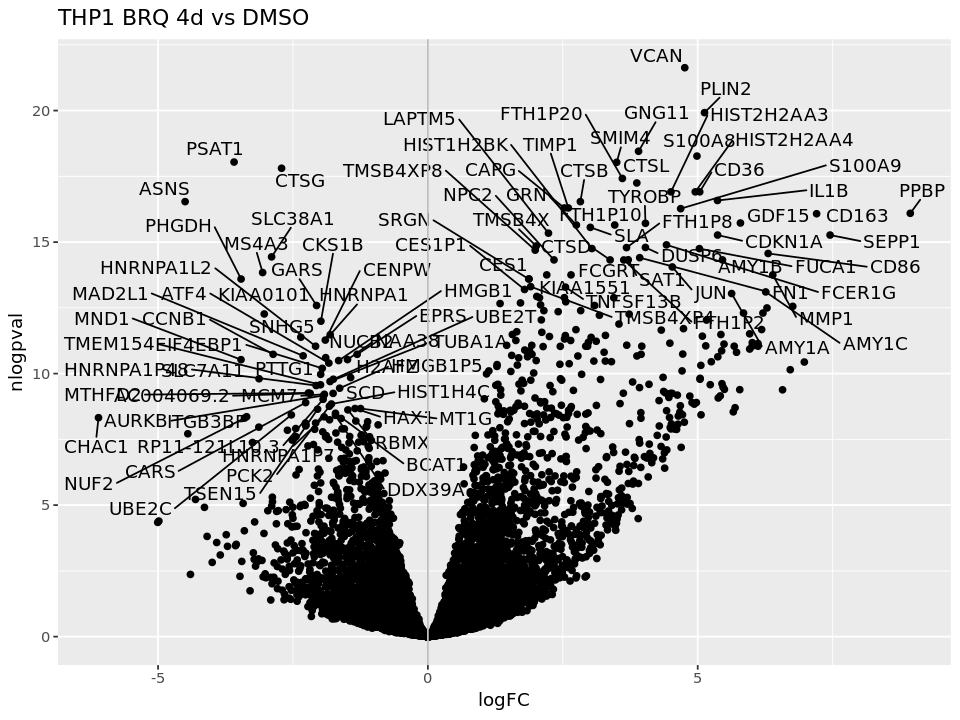

In [126]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(as.data.frame(brq4), aes(x=logFC, y=nlogpval, label=label)) + 
geom_point() + geom_text_repel() + geom_vline(xintercept = 0, color="gray") + ggtitle("THP1 BRQ 4d vs DMSO")
ggsave("../output/201113_thp1_brq4.pdf", width=8, height=6)

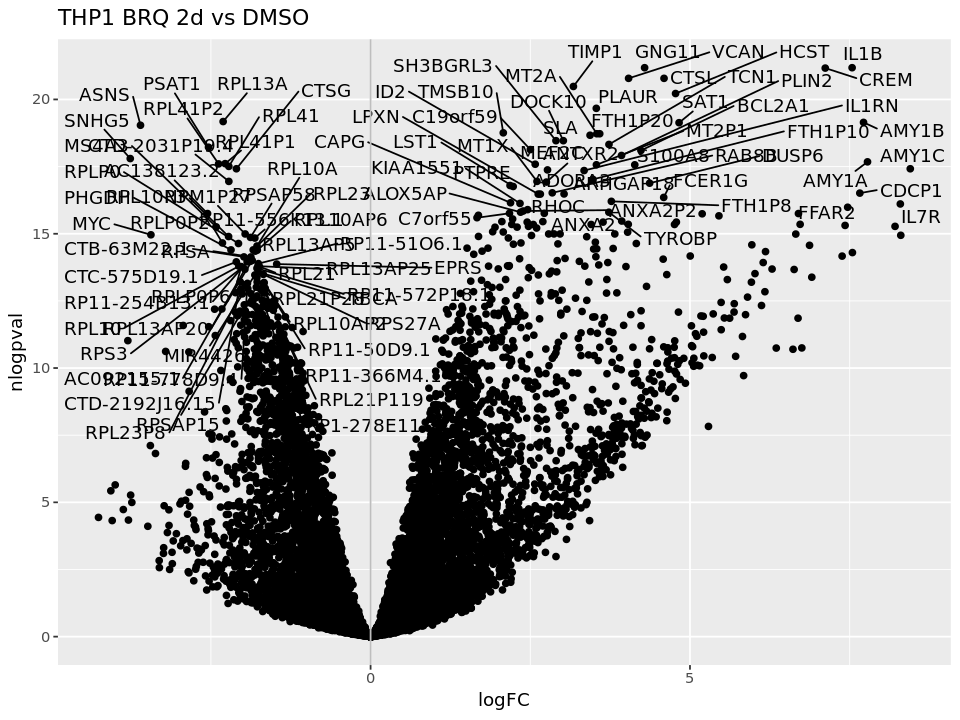

In [128]:
brq2 <- process_res(makeContrasts(condsTHP1_BRQ_2d - condsTHP1_DMSO, levels = colnames(coef(fit))))
write.csv(brq2, "../output/201112_thp1_brq2d.csv", quote=F)

ggplot(as.data.frame(brq2), aes(x=logFC, y=nlogpval, label=label)) + 
geom_point() + geom_text_repel() + geom_vline(xintercept = 0, color="gray") + ggtitle("THP1 BRQ 2d vs DMSO")
ggsave("../output/201113_thp1_brq2.pdf", width=8, height=6)

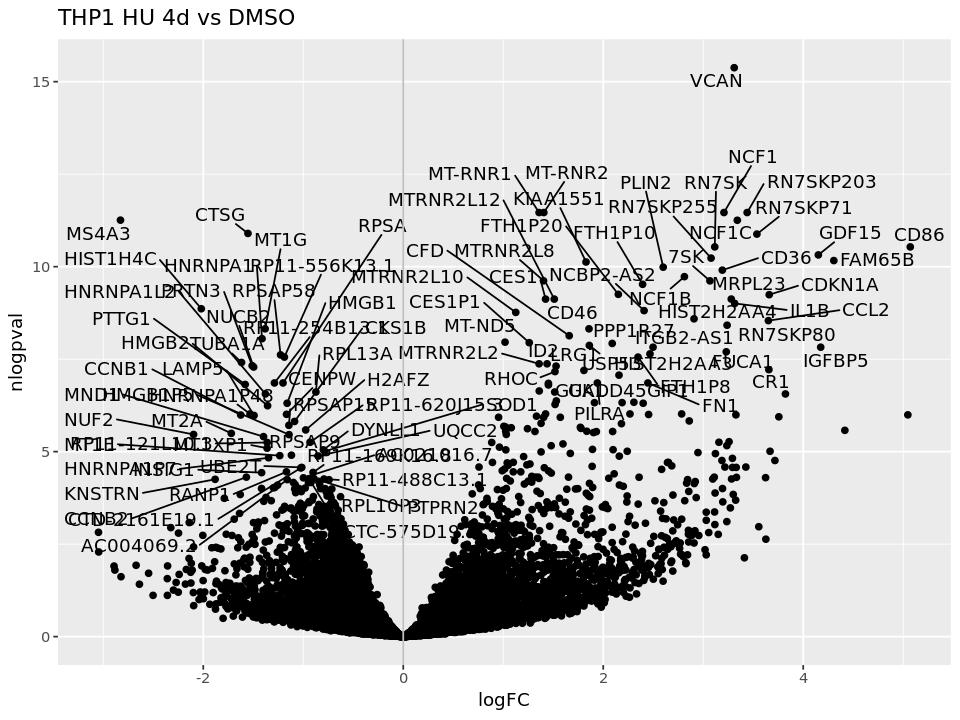

In [129]:
hu4 <- process_res(makeContrasts(condsTHP1_HU_4d - condsTHP1_DMSO, levels = colnames(coef(fit))))
write.csv(hu4, "../output/201112_thp1_hu4.csv", quote=F)

ggplot(as.data.frame(hu4), aes(x=logFC, y=nlogpval, label=label)) + 
geom_point() + geom_text_repel() + geom_vline(xintercept = 0, color="gray") + ggtitle("THP1 HU 4d vs DMSO")
ggsave("../output/201113_thp1_hu4.pdf", width=8, height=6)

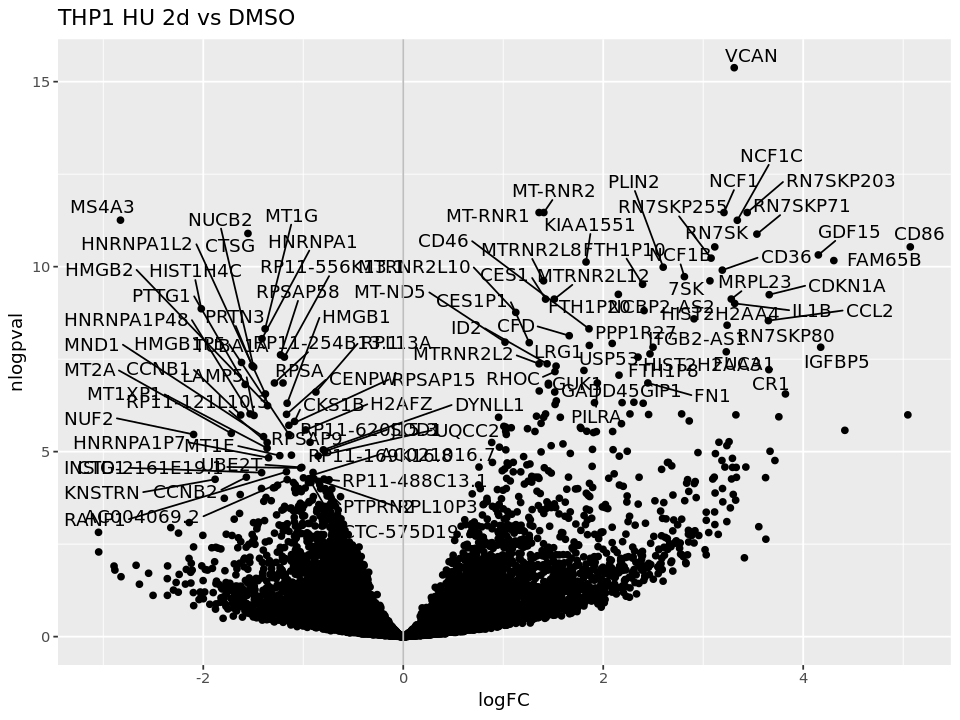

In [130]:
hu2 <- process_res(makeContrasts(condsTHP1_HU_2d - condsTHP1_DMSO, levels = colnames(coef(fit))))
write.csv(hu2, "../output/201112_thp1_hu2.csv", quote=F)

ggplot(as.data.frame(hu4), aes(x=logFC, y=nlogpval, label=label)) + 
geom_point() + geom_text_repel() + geom_vline(xintercept = 0, color="gray") + ggtitle("THP1 HU 2d vs DMSO")
ggsave("../output/201113_thp1_hu2.pdf", width=8, height=6)